<a href="https://colab.research.google.com/github/ChristianParsons98/YBCO_Data_Analysis/blob/main/Platinum_Temp_APD_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d

In [45]:
#Given R vs T conversion chart for Plat-100 series thermometer by manufacturer
#Temp in K
T = np.array([20, 30, 50, 77.35, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800])
#Resistance in Ohms
R = np.array([2.2913, 3.6596, 9.3865, 20.380, 29.989, 50.788, 71.011, 90.845, 110.354, 148.640, 185.668, 221.535, 256.243, 289.789])
#Derivative of R vs T
dR_dT = np.array([0.085, 0.191, 0.360, 0.423, 0.423, 0.409, 0.400, 0.393, 0.387, 0.383, 0.378, 0.372, 0.366, 0.360])

In [46]:
#Define spline interpolation from the data given by the manufacturer.
#Spline interpolation is used to keep the function smooth aroung points. Here, the derivative is continuous.
spline_interp = CubicSpline(R, T, bc_type='natural')

#Function which takes a measured resistance and returns the interpolated temperature.
#For efficiency, I am defining the Cubic spline outside of the function.
def interp_temp(R_input):
    return spline_interp(R_input)

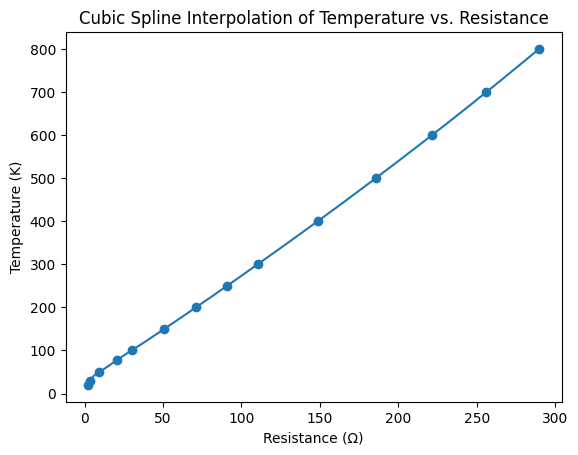

In [47]:
#Testing the interpolation.
# Generate fine-grained R values for smooth plotting
R_test = np.linspace(R.min(), R.max(), 500)
T_test = interp_temp(R_test)
plt.scatter(R, T)
plt.plot(R_test, T_test)
plt.xlabel('Resistance (Ω)')
plt.ylabel('Temperature (K)')
plt.title('Cubic Spline Interpolation of Temperature vs. Resistance')
#plt.xlim(0,40)
#plt.ylim(10,80)
plt.show()

In [48]:
#Point to the files of interest - this is the platinum thermometer data
Warming="/content/Plat_T_Warming.csv"
Cooling="/content/Plat_T_Cooling.csv"

In [49]:
#Import the file as pandas dataframes
dfWarming = pd.read_csv(Warming)
dfCooling = pd.read_csv(Cooling)

In [50]:
#Check that everything looks ok
dfWarming.head()

,Temperature_Forward(K),Average_Resistance(Ohms),V_Forward(V),ForwardI(Amps),R_ForwardI(Ohms),Temperature_Backward(K),V_Backward(V),BackwardI(Amps),R_Backward(Ohms),Time_Since_Start(s),True_Time(s)
0,23.53,-10.879223,-0.010875,0.001,-10.875126,23.53,0.010883,-0.001,-10.883320,2.091183,1.745351e+09
1,23.53,-10.876194,-0.010872,0.001,-10.872001,23.53,0.010880,-0.001,-10.880386,13.843132,1.745351e+09
2,23.53,-10.873168,-0.010869,0.001,-10.869003,23.53,0.010877,-0.001,-10.877333,25.858956,1.745351e+09
3,23.53,-10.870179,-0.010866,0.001,-10.866017,23.53,0.010874,-0.001,-10.874342,37.868659,1.745351e+09
4,23.53,-10.867209,-0.010863,0.001,-10.863024,23.53,0.010871,-0.001,-10.871394,49.896703,1.745351e+09


In [51]:
#Convert the columns into numpy arrays to do math and plot
#Warming Data
Warm_Temp = np.asarray(dfWarming['Temperature_Forward(K)'])
Warm_R = -np.asarray(dfWarming['Average_Resistance(Ohms)'])

#Cooling Data
Cool_Temp = np.asarray(dfCooling['Temperature_Forward(K)'])
Cool_R = -np.asarray(dfCooling['Average_Resistance(Ohms)'])

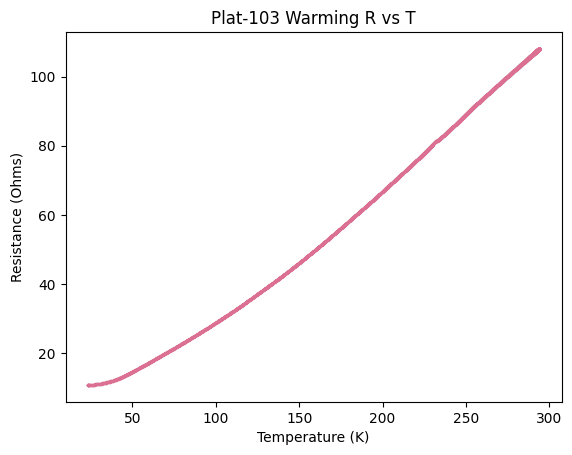

In [52]:
plt.scatter(Warm_Temp,Warm_R,color='palevioletred',s=1.90)
plt.title("Plat-103 Warming R vs T")
plt.ylabel("Resistance (Ohms)")
plt.xlabel("Temperature (K)")
#plt.savefig("YBCO_Warming_Full.png",dpi=900)
plt.show()


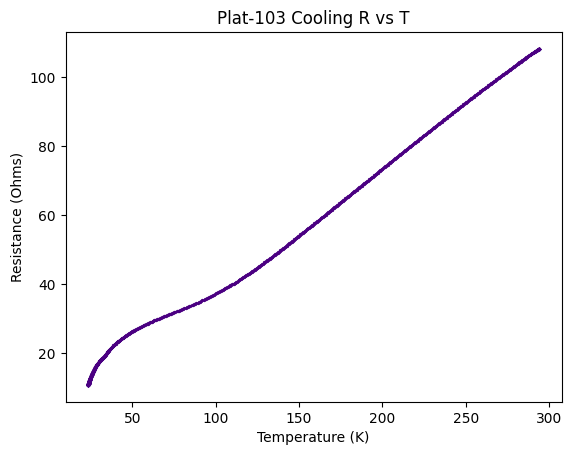

In [53]:
plt.scatter(Cool_Temp,Cool_R,color='Indigo',s=1.90)
plt.title("Plat-103 Cooling R vs T")
plt.ylabel("Resistance (Ohms)")
plt.xlabel("Temperature (K)")
#plt.savefig("YBCO_Cooling_Full.png",dpi=900)
plt.show()

In [54]:
#Now we convert R to Temp via the cubic interpolation above.
T_Inter_Cool = interp_temp(Cool_R)
T_Inter_Warm = interp_temp(Warm_R)

#Finding the difference between the Plat-103 temp and the system temp.
T_Dif_Cool = T_Inter_Cool - Cool_Temp
T_Dif_Warm = T_Inter_Warm - Warm_Temp

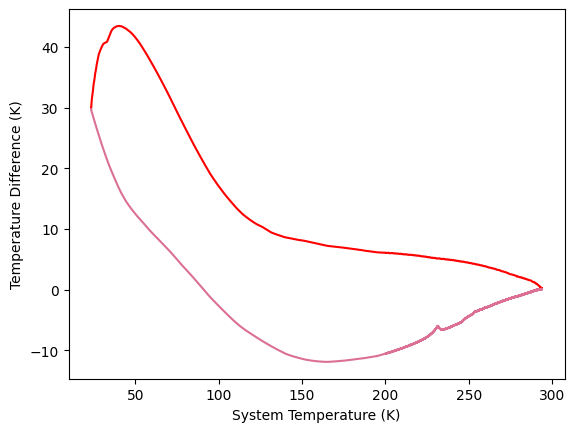

In [55]:
plt.plot(Cool_Temp, T_Dif_Cool, color='Red', label='Cooling')
plt.plot(Warm_Temp, T_Dif_Warm, color='palevioletred', label='Warming')
plt.xlabel("System Temperature (K)")
plt.ylabel("Temperature Difference (K)")
plt.show()

In [56]:
#Now we want to be able to interpolate the temperature difference for any system temperature.
#Here we just use a simple linear interpolation due to the density of data.
spline_interp_Cool = interp1d(Cool_Temp, T_Dif_Cool, kind='linear', fill_value='extrapolate')
spline_interp_Warm = interp1d(Warm_Temp, T_Dif_Warm, kind='linear', fill_value='extrapolate')

#Defining two functions for easy use.
def Corrected_Temp_Cool(TC_input):
    return spline_interp_Cool(TC_input)

def Corrected_Temp_Warm(TW_input):
    return spline_interp_Warm(TW_input)

In [57]:
#Make each column uniform.
Temp_Fine = np.linspace(Cool_Temp.min()+0.1, Warm_Temp.max(), 1000)
C_Temp_Cool_Fine = Corrected_Temp_Cool(Temp_Fine)
C_Temp_Warm_Fine = Corrected_Temp_Warm(Temp_Fine)

# Here we will save the conversion data into a csv for easy importing.
# Stack the arrays column-wise
data = np.column_stack((Temp_Fine,C_Temp_Cool_Fine,C_Temp_Warm_Fine))

# Save to CSV with headers
np.savetxt("Sample_Temp_Conv.csv", data,
           delimiter=",", header="T_Sys (K), T_Sample_Dif_Cool (K), T_Sample_Dif_Warm (K)",
           comments='', fmt='%.6f')